In [ ]:
import numpy as np  

import os
import matplotlib.pyplot as plt
import math as mt

from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D
from keras.layers.convolutional import Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist



In [ ]:
!pip install tensorflow==2.0.0


train shape: (60000, 28, 28)
test shape: (10000, 28, 28)
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
train shape after reshape: (60000, 1, 28, 28)
test shape after reshape: (10000, 1, 28, 28)

 Fold 0
Epoch 1/2
150/150 - 16s - loss: 1.7426 - accuracy: 0.3708 - val_loss: 0.8702 - val_accuracy: 0.6531 - 16s/epoch - 106ms/step
Epoch 2/2
150/150 - 15s - loss: 0.8742 - accuracy: 0.6623 - val_loss: 0.6932 - val_accuracy: 0.7396 - 15s/epoch - 100ms/step
Fold 0: Accuracy 73.96%

 Fold 1
Epoch 1/2
150/150 - 16s - loss: 1.6210 - accuracy: 0.4044 - val_loss: 0.8349 - val_accuracy: 0.6580 - 16s/epoch - 105ms/step
Epoch 2/2
150/150 - 15s - loss: 0.8328 - accuracy: 0.6883 - val_loss: 0.6901 - val_accuracy: 0.7414 - 15s/epoch - 100ms/step
Fold 1: Accuracy 74.14%
Accuracy scores:  [0.7396000027656555, 0.7414000034332275]
Mean Accuracy 0.740500
Stdev Accuracy 0.000900
Epoch 1/2
300/300 - 26s - loss: 1.3665 - accuracy: 0.4847 - val_loss: 0.7426 - val_accura

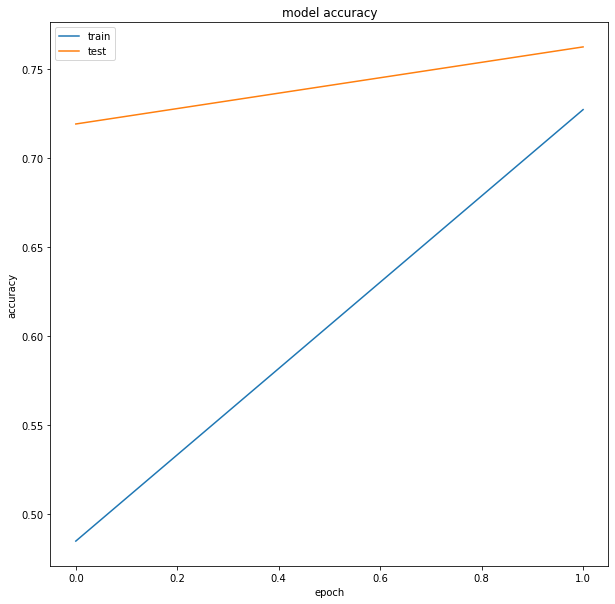

In [ ]:
seed = 7
np.random.seed(seed)

# define path to save model
model_path_cnn = '../Output/fm_cnn_model.h5'

# training configuration
batch_size = 200
epochs = 2
# prepare callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        verbose=1),
    ModelCheckpoint(
        model_path_cnn,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=0)
]

# k-fold configuration
n_splits = 2


def average(numbers):
    """
    Return the sample arithmetic mean of data.
    :param numbers: a list of float
    :return:
    """
    try:
        return float(sum(numbers)) / max(len(numbers), 1)
    except ZeroDivisionError:
        return 0


def sum_of_square_deviation(numbers, mean):
    """
    Return sum of square deviations of sequence data.
    :param numbers: a list of float
    :param mean:
    :return:
    """
    try:
        return float(1 / len(numbers) * sum((x - mean) ** 2 for x in numbers))
    except ZeroDivisionError:
        return 0


def model_cnn(num_classes):
    """Convolutional Neural Network

    The network topology can be summarized as follows:

        Convolutional layer with 32 feature maps of size 5×5.
        Pooling layer taking the max over 2*2 patches.
        Convolutional layer with 64 feature maps of size 5×5.
        Pooling layer taking the max over 2*2 patches.
        Convolutional layer with 128 feature maps of size 1×1.
        Pooling layer taking the max over 2*2 patches.
        Flatten layer.
        Fully connected layer with 1024 neurons and rectifier activation.
        Dropout layer with a probability of 50%.
        Fully connected layer with 510 neurons and rectifier activation.
        Dropout layer with a probability of 50%.
        Output layer.

    """
    # create model
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(1, 28, 28), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    lrate = 0.01
    decay = lrate / epochs
    sgd = SGD(learning_rate=lrate, momentum=0.9, decay=decay, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model


(x_train, y_train), (x_test, y_test)  = fashion_mnist.load_data()

print('train shape: {}'.format(x_train.shape))
print('test shape: {}'.format(x_test.shape))

unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

y_train_CNN = y_train  # only labels i.e targets digits
X_train_CNN = x_train.reshape(x_train.shape[0], 1, 28, 28).astype(np.uint8)
print('train shape after reshape: {}'.format(X_train_CNN.shape))

y_test_CNN = y_test  # only labels i.e targets digits
X_test_CNN = x_test.reshape(x_test.shape[0], 1, 28, 28).astype(np.uint8)
print('test shape after reshape: {}'.format(X_test_CNN.shape))

# normalize inputs from 0-255 to 0-1
X_train_CNN = X_train_CNN / 255
X_test_CNN = X_test_CNN / 255

# one hot encode outputs
y_train_CNN = to_categorical(y_train_CNN)
y_test_CNN = to_categorical(y_test_CNN)
num_classes = y_train_CNN.shape[1]

X_train = X_train_CNN
X_val = X_test_CNN
y_train = y_train_CNN
y_val = y_test_CNN

kf = KFold(n_splits=n_splits, random_state=seed, shuffle=True)
kf.get_n_splits(X_train)

acc_scores = list()

for fold, (train_index, test_index) in enumerate(kf.split(X_train)):
    print('\n Fold %d' % (fold))

    X_tr, X_v = X_train[train_index], X_train[test_index]
    y_tr, y_v = y_train[train_index], y_train[test_index]
    # build the model
    model = model_cnn(num_classes)
    # fit model
    model.fit(
        X_tr,
        y_tr,
        epochs=epochs,
        validation_data=(X_v, y_v),
        verbose=2,
        batch_size=batch_size,
        callbacks=callbacks,
        shuffle=True
    )

    acc = model.evaluate(X_v, y_v, verbose=0)
    acc_scores.append(acc[1])

    print('Fold %d: Accuracy %.2f%%' % (fold, acc[1] * 100))

print('Accuracy scores: ', acc_scores)

mean_acc = average(acc_scores)
standard_deviation_acc = mt.sqrt(sum_of_square_deviation(acc_scores, mean_acc))

print('=====================')
print('Mean Accuracy %f' % mean_acc)
print('=====================')
print('=====================')
print('Stdev Accuracy %f' % standard_deviation_acc)
print('=====================')

model = model_cnn(num_classes)
# Fit the final model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,
                    callbacks=callbacks, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_val, y_val, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))
print("Accuracy: %.2f%%" % (scores[1] * 100))

# summarize history for accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("../model_accuracy_fm_cnn.png")

